In [1]:
pip install fredapi

Note: you may need to restart the kernel to use updated packages.


In [2]:
from fredapi import Fred
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [20]:
fred = Fred(api_key = 'df603515721a15bd6485a50971128f86')

BTC_price = fred.get_series('CBBTCUSD', frequency = 'm')
gold_price = fred.get_series('ID7108', frequency = 'm')
SP500_index = fred.get_series('SP500', frequency = 'm')

In [21]:
BTC_price

2014-12-01         NaN
2015-01-01      228.33
2015-02-01      235.00
2015-03-01      270.12
2015-04-01      236.22
                ...   
2023-09-01    26305.66
2023-10-01    29754.17
2023-11-01    36595.67
2023-12-01    42547.52
2024-01-01         NaN
Length: 110, dtype: float64

In [22]:
gold_price

2001-12-01    100.0
2002-01-01     99.8
2002-02-01    101.8
2002-03-01    106.8
2002-04-01    106.4
              ...  
2023-07-01    695.7
2023-08-01    706.5
2023-09-01    697.6
2023-10-01    661.6
2023-11-01    721.1
Length: 264, dtype: float64

In [23]:
SP500_index

2014-01-01        NaN
2014-02-01    1817.03
2014-03-01    1863.52
2014-04-01    1864.26
2014-05-01    1889.77
               ...   
2023-09-01    4409.10
2023-10-01    4269.40
2023-11-01    4460.06
2023-12-01    4685.05
2024-01-01        NaN
Length: 121, dtype: float64

<Axes: title={'center': 'Price of Bitcoin'}, xlabel='Year', ylabel='Price (USD)'>

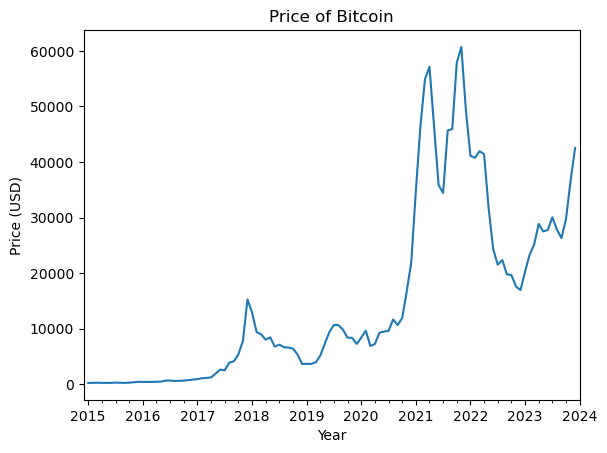

In [24]:
BTC_price.plot(title = 'Price of Bitcoin',
              xlabel = 'Year',
              ylabel = 'Price (USD)')

<Axes: title={'center': 'Price of gold'}, xlabel='Year', ylabel='Price (USD)'>

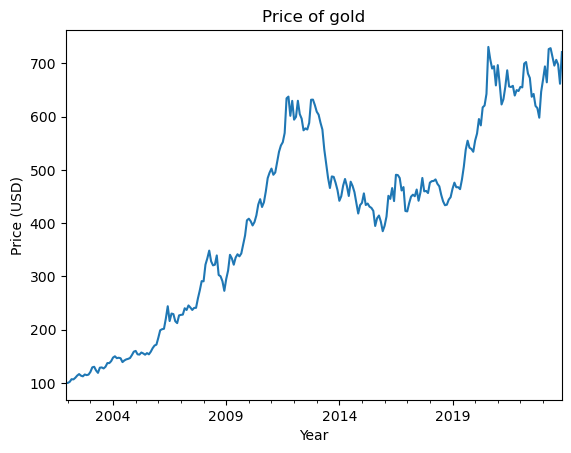

In [25]:
gold_price.plot(title = 'Price of gold',
               xlabel = 'Year',
               ylabel = 'Price (USD)')

<Axes: title={'center': 'S&P 500 Index'}, xlabel='Year', ylabel='Index'>

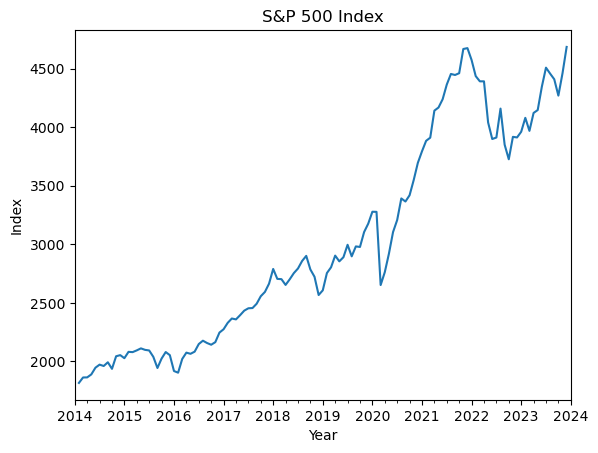

In [26]:
SP500_index.plot(title = 'S&P 500 Index',
                xlabel = 'Year',
                ylabel = 'Index')

In [40]:
data = pd.concat([BTC_price, gold_price, SP500_index], axis = 1)
data = data.fillna(method = 'ffill')
data = data.loc['2015-02-01':'2023-11-01']
data.columns = ['Bitcoin', 'gold', 'S&P 500']

data_returns = np.log(data/data.shift(1))
data_returns = data_returns.drop(data_returns.index[0])

In [41]:
data

,Bitcoin,gold,S&P 500
2015-02-01,235.00,455.8,2082.20
2015-03-01,270.12,433.9,2079.99
2015-04-01,236.22,436.7,2094.86
2015-05-01,237.43,430.8,2111.94
2015-06-01,238.42,428.5,2099.28
...,...,...,...
2023-07-01,30057.10,695.7,4508.08
2023-08-01,27849.98,706.5,4457.36
2023-09-01,26305.66,697.6,4409.10
2023-10-01,29754.17,661.6,4269.40


In [42]:
data_returns

,Bitcoin,gold,S&P 500
2015-03-01,0.139281,-0.049240,-0.001062
2015-04-01,-0.134103,0.006432,0.007124
2015-05-01,0.005109,-0.013603,0.008120
2015-06-01,0.004161,-0.005353,-0.006013
2015-07-01,0.162112,-0.013155,-0.002451
...,...,...,...
2023-07-01,0.079498,-0.022738,0.036760
2023-08-01,-0.076267,0.015405,-0.011315
2023-09-01,-0.057048,-0.012677,-0.010886
2023-10-01,0.123185,-0.052985,-0.032197


In [43]:
data_CAPM = data_returns.rename(columns = {'Bitcoin': 'risky_asset', 'gold': 'risk_free_asset', 'S&P 500': 'overall_market'})

y = data_CAPM['risky_asset'] - data_CAPM['risk_free_asset']
x = sm.add_constant(data_CAPM['overall_market'] - data_CAPM['risk_free_asset'])
CAPM_model = sm.OLS(y, x)
CAPM_model_results = CAPM_model.fit()
CAPM_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     25.09
Date:                Fri, 12 Jan 2024   Prob (F-statistic):           2.28e-06
Time:                        00:30:07   Log-Likelihood:                 38.401
No. Observations:                 105   AIC:                            -72.80
Df Residuals:                     103   BIC:                            -67.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0390      0.017      2.356      0.020       0.006       0.072
0              1.6192      0.323      5.009      0.000       0.978       2.260
==============================================================================
Omnibus:                        8.924   Durbin-Watson:                   1.284
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                8.791
Skew:                           0.609   Prob(JB):                       0.0123
Kurtosis:                       3.725   Cond. No.                         19.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
CAPM_alpha = CAPM_model_results.params['const']
CAPM_alpha

0.038765683067967655

In [39]:
CAPM_beta = CAPM_model_results.params[0]
CAPM_beta

1.6208273953794043

By the CAPM theory, 

$$
r_{bt} - r_{ft} = \alpha_{b} + \beta_{b}(r_{mt} - r_{ft}) + u_{bt}
$$

This equation intends to estimate the systematic risk ($\beta_{b}$) of risky asset ($r_{bt}$) as compared the other assets from the overall market ($r_{mt}$). The returns of risky, risk-free and overall market assets are represented by Bitcoin, gold and the S&P 500 market, respectively. These returns are calculated by taking the average of each component from 65 different monthly returns. The constant of the CAPM equation ($\alpha_{a}$) is also investigated to verify whether the strict form of CAPM holds, which is $\alpha_{a}$ equals 0 to indicate there isn't any idiosyncratic unpredictable error ($u_{bt}$).

According to the OLS regression generated by the package "statsmodel.api", the constant is 0.039, suggesting the existance of  idiosyncratic unpredictable error. It means that the expected returns of Bitcoin cannot be fully explained by $\beta_{b}$ and return of gold, which is presumably risk-free asset. The positive constant advocates that Bitcoin has outperformed the market expectation of generating excessive returns that can only be explained by idiosyncratic unpredictable factors. 

The systematic risk of Bitcoin is recorded as 1.62, this value is above the average systematic risk of assets in S&P 500 market. In other words, Bitcoin is more volatile as compared to the general S&P 500 market.   